In [16]:
import tqdm
import fasttext
import itertools
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cosine

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from sklearn.decomposition import LatentDirichletAllocation

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.decomposition import TruncatedSVD

pd.options.mode.chained_assignment = None 

#nltk.download('wordnet')

C:\Users\Vincelot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    wor_tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in wor_tokens if word not in stop_words]
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [12]:
model_path = "Models/clean_cbow_model.bin"
data_path = 'Data\submission_and_comments_V3.csv'

model = fasttext.load_model(model_path)
stop_words=set(nltk.corpus.stopwords.words('english'))

all_data = pd.read_csv(data_path, sep = ";")
data = all_data[(all_data.submission_title != "[deleted by user]") & ~(all_data.submission_title.isna())]
data['clean_submission_title'] = data['submission_title'].apply(clean_text)
concat_posts = np.array(data['clean_submission_title'])
embbed_data = [model[post] for post in concat_posts]

vectorizer = TfidfVectorizer(stop_words = list(stop_words), max_df=0.95)
tf_idf = vectorizer.fit_transform(data['clean_submission_title'])

In [13]:
lda_model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=1) 
lda_topics = lda_model.fit_transform(tf_idf)

In [17]:
umap_reducer = umap.UMAP(metric = "cosine", verbose = True, n_neighbors = 200, min_dist = 0)
umap_embedding = umap_reducer.fit_transform(lda_topics)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=200, verbose=True)
Sat Jun  3 21:16:07 2023 Construct fuzzy simplicial set
Sat Jun  3 21:16:07 2023 Finding Nearest Neighbors
Sat Jun  3 21:16:07 2023 Building RP forest with 12 trees
Sat Jun  3 21:16:11 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sat Jun  3 21:16:53 2023 Finished Nearest Neighbor Search
Sat Jun  3 21:17:00 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:28]

Sat Jun  3 21:17:33 2023 Finished embedding


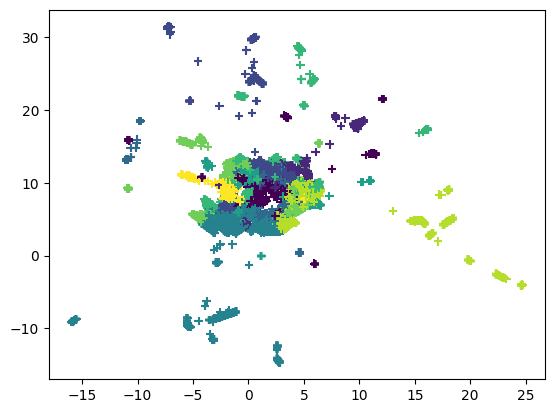

In [47]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],  c = topic_labels, marker = "+")

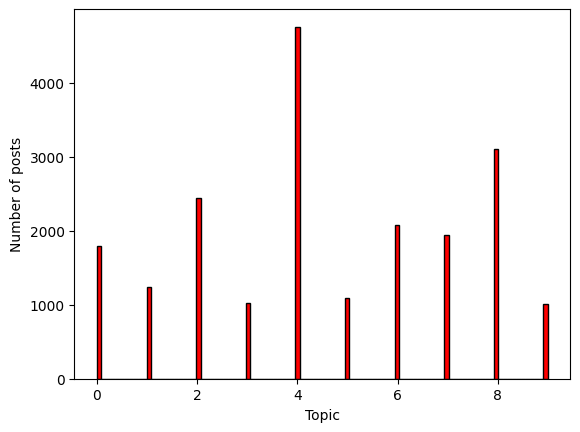

In [41]:
topic_labels = np.argmax(lda_topics, axis = 1)
_ = plt.hist(topic_labels, bins = 100, edgecolor = "black", color = 'r')
plt.xlabel('Topic')
plt.ylabel('Number of posts')
plt.show()

In [42]:
supervised_umap_reducer = umap.UMAP(metric = "cosine", verbose = True, n_neighbors = 200, min_dist = 0)
supervised_umap_embedding = umap_reducer.fit_transform(lda_topics, y = topic_labels)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_neighbors=200, verbose=True)
Sat Jun  3 21:27:07 2023 Construct fuzzy simplicial set
Sat Jun  3 21:27:07 2023 Finding Nearest Neighbors
Sat Jun  3 21:27:07 2023 Building RP forest with 12 trees
Sat Jun  3 21:27:07 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Sat Jun  3 21:27:37 2023 Finished Nearest Neighbor Search
Sat Jun  3 21:27:41 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:42]

Sat Jun  3 21:28:34 2023 Finished embedding


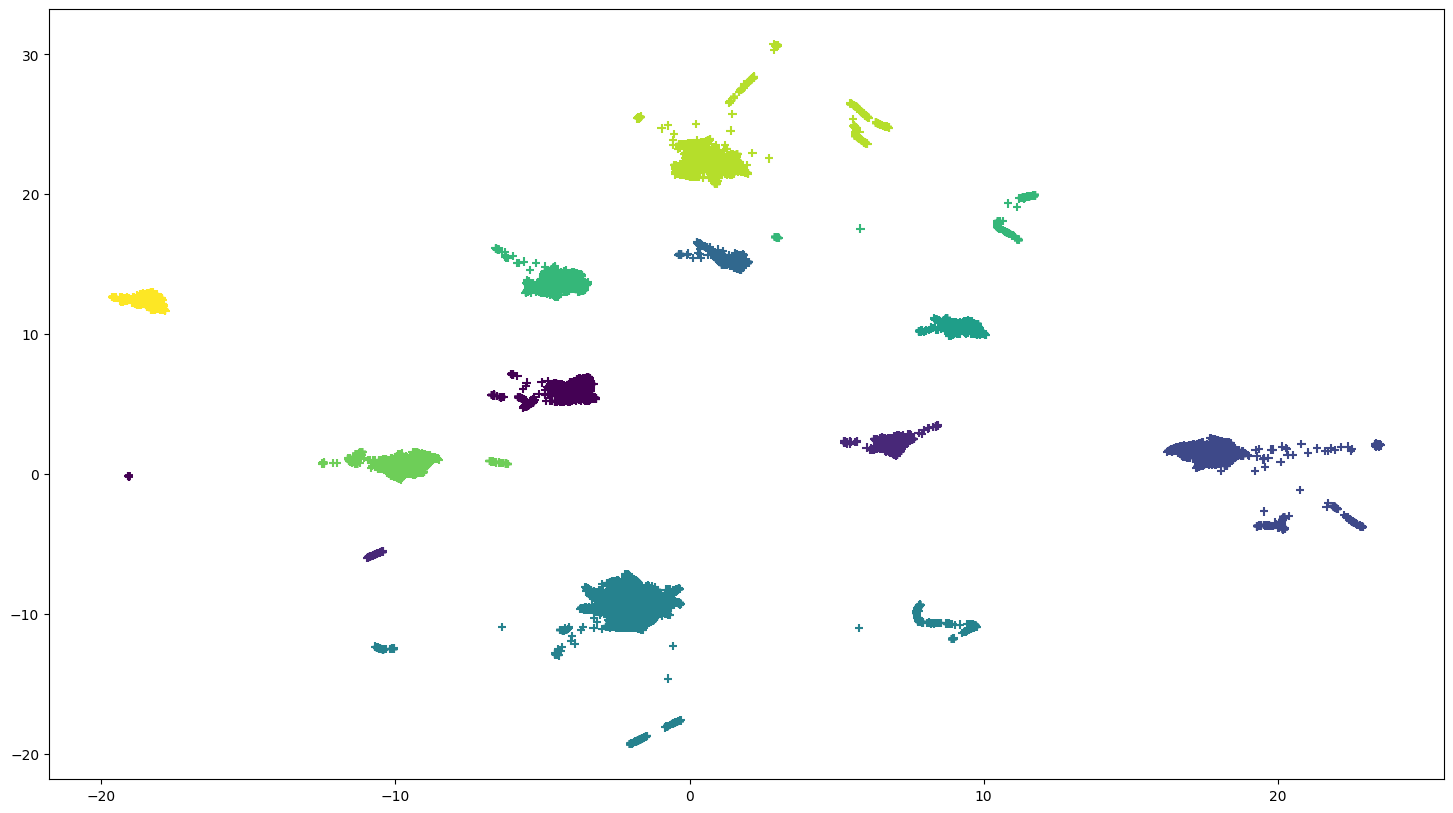

In [46]:
plt.figure(figsize = (18, 10))
plt.scatter(supervised_umap_embedding[:, 0], supervised_umap_embedding[:, 1],  c = topic_labels, marker = "+")